# Problem Set 4

In [377]:
# import pandas as pd
# import numpy as np
# from scipy.io import loadmat  # this is the SciPy module that loads mat-files
# from scipy.optimize import root, minimize
# import matplotlib.pyplot as plt
# from jax import grad, jacobian, hessian, config, jit, lax
# import jax.numpy as jnp
# import warnings

# config.update("jax_enable_x64", True)

from source_functions import *

In [378]:
# Set global parameter values
beta = (5, 1, 1)
gamma = (2, 1, 1)

In [379]:
df_3p, alphas_3p = load_mat_data('Simulation Data/100markets3products.mat', 3, 100)
df_5p, alphas_5p = load_mat_data('Simulation Data/100markets5products.mat', 5, 100)

In [380]:
epsilons_3p = draw_epsilons(alphas_3p)
epsilons_5p = draw_epsilons(alphas_5p)

In [381]:
# Calculate marginal costs for the firms
df_3p['mc'] = gamma[0] + gamma[1]*df_3p['w'] + gamma[2]*df_3p['Z'] + df_3p['eta']
df_5p['mc'] = gamma[0] + gamma[1]*df_5p['w'] + gamma[2]*df_5p['Z'] + df_5p['eta']

In [382]:
# Calculate profits per purchase for the firms
df_3p['Pi'] = df_3p['P_opt'] - df_3p['mc']
df_5p['Pi'] = df_5p['P_opt'] - df_5p['mc']

In [383]:
consumer_welfare_3p = calculate_welfare(df_3p, alphas_3p, beta, epsilons_3p)
consumer_welfare_5p = calculate_welfare(df_5p, alphas_5p, beta, epsilons_5p)

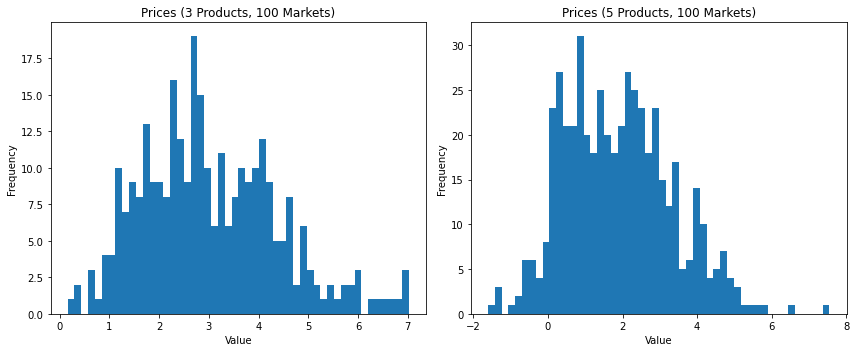

In [384]:
plot_two_histograms(df_3p['P_opt'].values, df_5p['P_opt'].values, bins=50, labels=('Prices (3 Products, 100 Markets)', 'Prices (5 Products, 100 Markets)'))

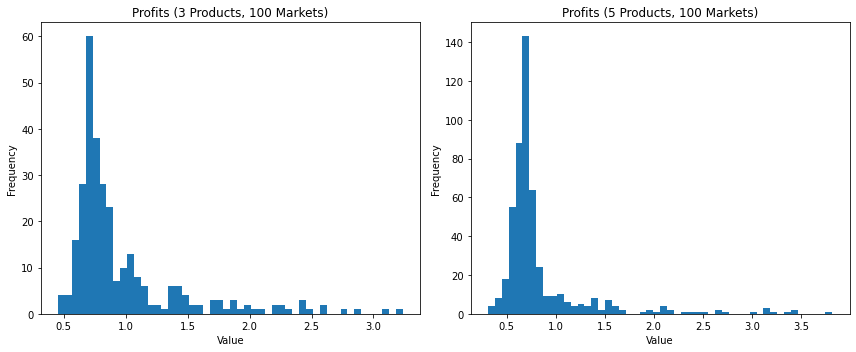

In [385]:
# NOTE: This is incomplete. Need to calculate gross profits accounting for the consumer choices. Currently, it's just per purchase profits.

plot_two_histograms(df_3p['Pi'].values, df_5p['Pi'].values, bins=50, labels=('Profits (3 Products, 100 Markets)', 'Profits (5 Products, 100 Markets)'))

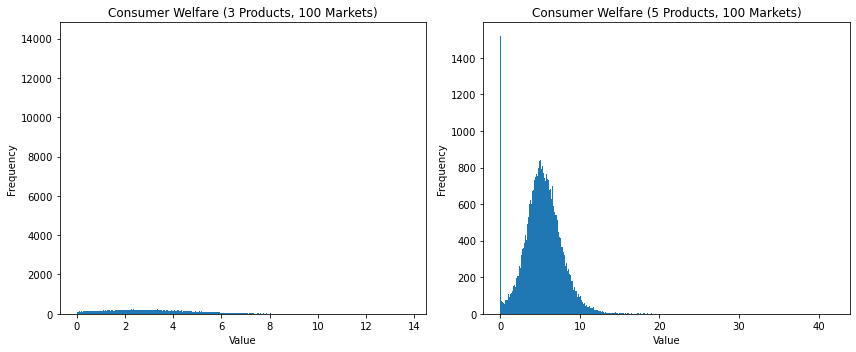

In [387]:
plot_two_histograms(consumer_welfare_3p, consumer_welfare_5p, labels=('Consumer Welfare (3 Products, 100 Markets)', 'Consumer Welfare (5 Products, 100 Markets)'))

# 2. BLP and Hausman Instruments

In [388]:
# Set the number of firms, markets, and simulated consumers in each market 
J = 3
M = 100
N = 500

In [389]:
# Set the number of BLP instruments
N_instruments = 7

### 1. (a)

NOTE: We assume the question asks us to use the $(J, M) = (3, 100)$ data set, since there is no data with 200 markets.

In [390]:
df_3p['P_other_markets'] = df_3p.groupby('product_id')['P_opt'].transform(
        lambda x: (x.sum() - x) / (len(x) - 1)
    )

In [391]:
xi = df_3p['xi_all'].values.reshape(J*M, 1)
X = df_3p[['x1', 'x2', 'x3']].values.reshape(J*M, 3)
price = df_3p['P_opt'].values.reshape(J*M, 1)
price_other_mkt = df_3p['P_other_markets'].values.reshape(J*M, 1)

In [392]:
(xi*X).mean(axis=0)

array([0.04346104, 0.02074192, 0.0355315 ])

In [393]:
(xi*price).mean()

0.2949581371489729

In [394]:
(xi*price_other_mkt).mean()

0.1436795476746802

### 1. (b)

Consider $E[\xi|X] = 0$ first. For the moment condition to be valid for all $X$ (including the firm's own product characteristics), we would need the observable product characteristics $X_{jm}$ to be independent of the unobserved product characteristics (or things like market-specific brand value), $\xi_{jm}$. In practice, this would mean that firms with certain types of observable product characteristics do not have systematically different unobserved product characteristics. This seems unlikely to hold in practice, since firms are able to both see the unobserved (to the econometrician) product characteristics before choosing the observed (again, to the econometrician) product characteristics. For example, we would expect that a "premium" car (something that is in $\xi$) typically has different product characteristics that a non-premium car. Still, to know whether this moment condition would be valid in this context, we would need more information on what type of products we are studying.

The moment condition is relevant though, as long as $X$ is included $Z_{jm}$, i.e. the product characteristics are costly. The relevance is then clear from the fact that prices are a function of marginal costs, which are a function of $X$.  

As for $E[\xi|p] = 0$, the validity depends on which prices we consider. With own prices, it's clear that validity is not satisfied, since in general, prices are higher for products with greater $\xi$, as firms choose prices with knowledge of their market-specific $\xi_{jm}$. But the mean independence might be satisfied for own prices in other markets (Hausman instruments), if we include firm fixed effects to control for the firm-level component of $\xi$ that is invariant accross markets and construct the moment condition with the market-specific part of $\xi$. Note that relevance is trivially satisfied in both these cases, since (1) prices are obviously correlated with themselves, and (2) prices in other markets are correlated with prices in a specific market because there is a common cost shifter for all markets, $W_j$. 

### 1. (c)

If the way firms choose product characteristics $X$ is such that the unobserved product characteristics are not observed before choosing observable characteristics, the BLP instruments can be used. Similarly, in the previous part we have argued that the Hausman instruments are relevant, and are also valid if there are e.g. no demand shocks that are common accross all markets or marketing campaings of the firms that include multiple markets.

### 2. (a)

To begin, we introduce some notation that is useful throughout the rest of the problem set. Let $S_{jm}$ be the observed market share of product $j$ in market $m$, and $S_m \equiv (S_{jm})_{j = 1}^J$. For each value of the parameter values $\theta$, there exists a unique mapping (as shown by Berry, 1994) between the observed market shares, $S_m$, and the vector of unobserved demand shocks $\xi_m$, defined by $s(\cdot)$:
$$
S_m = s(X_m, p_m, \xi_m; \theta),
$$
where the $X_m$ is the matrix of observed product characteristics, $p_m$ the vector of prices, and $\xi_m$ the vector of unobserved demand shocks, all in market $m$. The uniqueness of the mapping allows us to invert the market share function to arrive at:
$$
\xi_m(\theta) = s^{-1}(S_m; \theta),
$$
where we have shortened $s(\xi_m; \theta) \equiv s(X_m, p_m, \xi_m; \theta)$ for notational convenience. Finally, denote $\xi(\theta) = (\xi_m(\theta))_{m = 1}^M$.

We next write down the BLP moments. First, let $h(X, j, m)$ be a vector valued function of moments for firm $j$ in market $m$, based on all the observable product characteristics $X$ for all products and markets. The BLP instruments are the (observable) product characteristics of the firm $X_{jm}$, the sum of the characteristics of other products of the firm (in other markets) $\sum_{r \neq j, m' \neq m, r \in \mathcal{F}_j} X_{rm'}$, and the characteristics of other firms in the same market $\sum_{r \neq \mathcal{F}_j} X_{rm}$. We exclude the first element of $X_{jm}$, the constant, from all these instruments. Since there are two other product characteristics, $h(X)$ is a vector with $2 \times 3 = 6$ elements for each firm. The BLP moment is thus:
$$
E[\xi_{jm}h(X, j)] = 0.
$$

The empirical analogue of the BLP moment is:
$$
g(\xi(\theta)) = \frac{1}{M}\Sigma_{m = 1}^M \Sigma_{j = 1}^J \xi_{jm} h(X, j, m).
$$
Let $s^{-1}_j(S_m; \theta)$ denote the $j$th element of $s^{-1}_j(S_m; \theta)$. We thus have:
$$
g(\xi(\theta)) = \frac{1}{M}\Sigma_{m = 1}^M \Sigma_{j = 1}^J s^{-1}_j(S_m; \theta) h(X, j, m).
$$

### 2. (b)

The objective function in the MPEC problem is simply:
$$
Q(\theta) \equiv g(\xi(\theta))^T W g(\xi(\theta)),
$$
for some weighting matrix $W$. We can thus write the MPEC problem in its entirety as:
$$
\begin{aligned}
\min _{\theta, \xi, \eta} \eta^{\prime} W \eta & \\
\text { subject to } & g(\xi)=\eta, \\
& s(\xi ; \theta)=S.
\end{aligned}
$$

# Here's code that is compatible with the $\delta$ approach (as opposed to the $\xi$ approach).

In [395]:
X = jnp.array(df_3p[['x1', 'x2', 'x3']].values)
prices = jnp.array(df_3p[['P_opt']].values)
shares = jnp.array(df_3p[['shares']].values)

In [396]:
sigma_alpha_init = 1
eta_init =  jnp.ones((N_instruments, 1))
delta_init = jnp.ones((J*M, 1))
params_init = jnp.concatenate([np.array([sigma_alpha_init]).reshape(-1,1), eta_init, delta_init], axis=0).flatten()

# For speed, compute this outside of the function and pass it later
alphas_repeat = jnp.repeat(np.array(alphas_3p.values), repeats=J, axis=0)

# Random coefficients nu on the prices
nus_on_prices = (alphas_repeat-1) * prices.reshape(-1, 1)

In [397]:
deltas_correct = (5 + df_3p['x2'] + df_3p['x3'] - df_3p['P_opt'] + df_3p['xi_all']).values.reshape(300, -1)

In [398]:
# Prepend the new element
first_elems = jnp.ones(1+N_instruments).reshape(-1, 1)
params_correct = jnp.vstack([first_elems, deltas_correct]).reshape(-1)

# Define parameters: 

In [399]:
M=100
J=3
N_instruments=7
N=500
MJN = (M, J, N_instruments, N)

In [411]:
#### Solve initial deltas for improved initial guess. 
res = solve_init_deltas(params_init, shares, nus_on_prices, MJN)

In [403]:
# Get matrix of regressors
Xbar = df_3p[['x1', 'x2', 'x3', 'P_opt']].values.reshape(J*M, 4)

# Get the matrix of instruments (including x1, x2, and the BLP moments). 
Z = jnp.array(blp_instruments_all(X, MJN))

#Projection matrix onto the instruments
Pz = Z @ jnp.linalg.inv(Z.T @ Z) @ Z.T
#Annihiliator matrix to get xi from delta
Az = jnp.eye(Pz.shape[0]) - Xbar @ jnp.linalg.inv(Xbar.T @ Pz @ Xbar) @ Xbar.T @ Pz
#This thing gets the value of beta.
M_iv_est = (np.linalg.inv(Xbar.T @ Pz @ Xbar) @ Xbar.T @ Pz)
# GMM weighting matrix
W = np.eye(N_instruments)

In [406]:
# Define the constraints list
constraints = [
    {
        'type': 'eq',  # Equality constraint g(x) = eta
        'fun': lambda x: np.asarray(constraint_g(x, Z, Az, MJN)),  # Convert to NumPy
        'jac': lambda x: np.asarray(constraint_g_jac(x, Z, Az, MJN))  # Convert Jacobian to NumPy
    },
    {
        'type': 'eq',  # Equality constraint s(x) = shares
        'fun': lambda x: np.asarray(constraint_s(x, shares, nus_on_prices, MJN)),
        'jac': lambda x: np.asarray(constraint_s_jac(x, shares, nus_on_prices, MJN))
    }
]

In [407]:
# Silence warning about delta_grad==0.0
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

# Solve optimization
tolerance = 1e-34
W = np.eye(N_instruments)

result = minimize(
    fun=lambda x: objective_mpec(x, W, MJN),
    x0=params_init,
    constraints=constraints,
    method='trust-constr',
    jac=lambda x: objective_jac(x, W, MJN),
    hess=lambda x: objective_hess(x, W, MJN),
    options={'xtol': tolerance,
             'gtol': tolerance,
             'barrier_tol': tolerance,
             'sparse_jacobian': True,
             'disp': True,
             'verbose': 3
            }, 
)

# Output results
if result.success:
    print("Optimal solution:", result.x)
else:
    print("Optimization failed:", result.message)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------|
|   1   |   1   |   0   | +7.0000e+00 | 1.00e+00 | 1.81e-04 | 1.00e+00 | 1.00e+00 |   0   |
|   2   |   2   |   1   | +4.5000e+00 | 5.60e+00 | 2.52e-04 | 8.02e-01 | 1.00e+00 |   1   |
|   3   |   3   |   2   | +1.8362e-01 | 3.14e+01 | 7.07e-05 | 4.13e-01 | 5.64e+01 |   1   |
|   4   |   4   |   3   | +6.6574e-02 | 1.12e+02 | 2.02e-04 | 1.06e-01 | 4.19e+02 |   1   |
|   5   |   5   |   4   | +4.3206e-02 | 1.12e+02 | 1.65e-04 | 2.49e-02 | 4.19e+02 |   1   |
|   6   |   6   |   5   | +3.2150e-02 | 1.12e+02 | 1.74e-04 | 3.81e-03 | 6.88e+02 |   1   |
|   7   |   7   |   6   | +4.7792e-02 | 1.12e+02 | 4.78e-04 | 8.67e-04 | 6.88e+02 |   1   |
|   8   |   8   |   7   | +7.2791e-02 | 1.12e+02 | 6.86e-04 | 2.59e-04 | 6.88e+02 |   1   |
|   9   |   9   |   8   | +9.1617e-02 | 1.12e+02 | 8.00e-04 | 6.65e-05 | 7.07e+0

KeyboardInterrupt: 

In [408]:
result

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 0.007858522534562451
                x: [ 9.888e-01 -6.374e-15 ...  4.559e+00  4.951e+00]
              nit: 662
             nfev: 1177
             njev: 578
             nhev: 578
         cg_niter: 560
     cg_stop_cond: 2
             grad: [ 0.000e+00 -1.275e-14 ...  0.000e+00  0.000e+00]
  lagrangian_grad: [-1.030e-18 -1.578e-30 ...  8.674e-19  4.337e-19]
           constr: [array([ 4.131e-19,  4.459e-19,  5.394e-19, -1.388e-17,
                           3.469e-18,  4.337e-19,  0.000e+00]), array([ 0.000e+00,  0.000e+00, ...,  2.776e-17,
                           0.000e+00])]
              jac: [<7x308 sparse matrix of type '<class 'numpy.float64'>'
                   	with 2103 stored elements in Compressed Sparse Row format>, <300x308 sparse matrix of type '<class 'numpy.float64'>'
                   	with 1200 stored elements in Compressed Sparse Row

In [409]:
# Calculate betas
thetastar = result.x #Get the estimated "true" value of theta
delta_hat = thetastar[N_instruments + 1:].reshape(300, 1)
beta_hat = M_iv_est  @ delta_hat

In [410]:
beta_hat

Array([[ 4.92818632],
       [ 0.95515674],
       [ 1.02872379],
       [-0.96756758]], dtype=float64)

### Standard Errors
The variance-covarience matrix is: 
$$
    V_{GMM} = \left[G^\intercal G\right]^{-1}G^\intercal \bar B G \left[G^\intercal G\right]^{-1}
$$
where
$$
    G \approx \frac{1}{JM} \sum_{j,t} \frac{\partial g(\theta)}{\partial \theta}, 
$$
$$
    \bar B \approx \frac{1}{JM} \sum_{j,t} g(\theta)g(\theta)^\intercal, 
$$

Here, the function $g(\theta)$ represents the vector of moment conditions (before averaging):
$$
    g(\theta) = f(z_{jm})\xi_{jm}
$$


### Calculate G.
To derive $d\delta/d\sigma,$ totally differentiate the share-matching constraint:
$$
S(\delta, \sigma) - s = 0
$$
$$
\nabla_\theta S(\delta, \sigma) = 0
$$
$$
\underbrace{D_\delta S(\delta, \sigma)}_{JM\times J_M} \underbrace{d\delta}_{JM\times 1} +  \underbrace{\frac{\partial S(\delta, \sigma)}{\partial \sigma}}_{JM\times 1} \underbrace{d\sigma}_{1\times 1} = 0
$$
$$
    \frac{d\delta}{d\sigma} = - \left[D_\delta S(\delta, \sigma)\right]^{-1} \left[\frac{\partial S(\delta, \sigma)}{\partial \sigma}\right]
$$

In total, the matrix $G$ is given by: 

$$
\frac{1}{JM} Z^\intercal A_z \begin{bmatrix}
     \frac{d\delta}{d\sigma}_{JM\times 1}& \mathbf 0_{JM\times n_I} & \mathbb I_{JM\times JM} \end{bmatrix}
$$

In [356]:
se_sigma, se_betas = standard_errors(thetastar, Z, Az, M_iv_est, shares, nus_on_prices, MJN)

In [357]:
se_betas

array([0.271207  , 0.21354112, 0.06062612, 0.09132179])

### Standard errors should get lower if we use this VCV matrix to derive the optimal weigting matrix and run it again

# Supply Side
$$
MC_{j m}=\gamma_0+\gamma_1 W_j+\gamma_2 Z_{j m}+\eta_{j m}
$$

### Moment using cost shifter, $W$
We use the moment condition $E\left[\xi W\right]$ = 0. This will hold if:

* Relevance: $W_j$ is correlated with cosnumer utility, because it affects the price $P_{jm},$
* Exclusion: $W_j$ affects consumer utility only through the price. This makes sense if it's something like steel prices, and the product is cars.  
* Exogeneity: $W_j$ is uncorrelated with the unobserved demand shock $\xi_{jm}$

Then, the new matrix of instruments will be

$$
\bar Z = \begin{bmatrix}
    \mathbf 1 & \mathbf x_1 & \mathbf x_2 & \mathbf {\bar x_{1,j}} & \mathbf{\bar x_{2,j}} & \mathbf{\bar x_{1,m}} & \mathbf{\bar x_{2,m}} & \mathbf W
\end{bmatrix}
$$

In [51]:
#### Store all the old variables
# xi = df_3p['xi_all'].values.reshape(J*M, 1)
# X = df_3p[['x1', 'x2', 'x3']].values.reshape(J*M, 3)
# price = df_3p['P_opt'].values.reshape(J*M, 1)
# price_other_mkt = df_3p['P_other_markets'].values.reshape(J*M, 1)
#### eventually, we will change the code to use flexible .py functions
Z0=Z
N_instruments0 = N_instruments




In [52]:
Wshifter = df_3p[['w']].values.reshape(J*M, 1)
Z = jnp.concatenate([Z, Wshifter], axis=1)
# Projection matrix onto the instruments
Pz = Z @ jnp.linalg.inv(Z.T @ Z) @ Z.T
# Construct the annihilator matrix
Az = jnp.eye(Pz.shape[0]) - Xbar @ jnp.linalg.inv(Xbar.T @ Pz @ Xbar) @ Xbar.T @ Pz
# matrix which gets the IV estimate for beta, when we multiply it with delta. 
M_iv_est = (np.linalg.inv(Xbar.T @ Pz @ Xbar) @ Xbar.T @ Pz)